# Meteorite Landings - Problematic and Data Analysis

Data source: [https://www.kaggle.com/nasa/meteorite-landings](https://www.kaggle.com/nasa/meteorite-landings)
<br>
Meteorite classification: [https://en.wikipedia.org/wiki/Meteorite_classification](https://en.wikipedia.org/wiki/Meteorite_classification)

## Data Quality

According to the [Kaggle Dataset Page](https://www.kaggle.com/nasa/meteorite-landings), a few dates are incorrectly parsed
and are either < 860 BCE or > 2016. There may be some other errors.

Some entries have a latitude-longitude value of 0N/0E, they are probably incorrect because these are meteorites whose precise
landing could not be know (e.g. meteor spotted landing over the ocean), or whose landing location was simply not reported.
It is worth noting that many of these were discovered in Antartica, but no better location information is recorded in the dataset.

Just for good measure, let's check the indicated masses are correct, we remove masses indicated as 0.0.
Below we filter the data, indicate the number of invalid entries and keep the incomplete/invalid entries in separate datasets.

In [1]:
import matplotlib.pyplot as plt, pandas as pd, re

RAW_DATA_FILE = "MeteoriteLandings.csv"
VALID_DATA_FILE = f"{RAW_DATA_FILE[:-4]}_Valid.csv"
INVALID_DATA_FILE = f"{RAW_DATA_FILE[:-4]}_Invalid.csv"

# Read raw data from CSV file
raw_data = pd.read_csv(RAW_DATA_FILE)

# Filter data and extract years
date_regex = re.compile(r'^\d+/\d+/(\d+) \d+:\d+:\d+ (AM|PM)$')

def valid_date(year):
    match = date_regex.match(year)
    if not match:
        return False
    
    year = int(match.group(1))
    return year >= 860 and year <= 2016

def extract_year(row):
    match = date_regex.match(row.year)
    updated = row.copy()
    updated.year = match.group(1)
    return updated

def filter_data(df):
    year_flags = df.year.astype(str).apply(valid_date)
    mass_flags = df.mass.astype(float) > 0.0
    geoloc_flags = (df.reclat >= -90) & (df.reclat <= 90) & (df.reclong >= -180) & (df.reclong <= 180) & ((df.reclat != 0.0) | (df.reclong != 0.0))
    flags = year_flags & mass_flags & geoloc_flags
    return df[flags].apply(extract_year, axis='columns'), df[~flags]

valid_data, invalid_data = filter_data(raw_data)
valid_data.to_csv(VALID_DATA_FILE)
invalid_data.to_csv(INVALID_DATA_FILE)

In [16]:
# Display cleaning results
valid_num, invalid_num, total_num = len(valid_data), len(invalid_data), len(raw_data)
valid_percentage = int(valid_num * 100 / total_num)
print(f"{valid_num} valid lines out of {total_num} lines ({valid_percentage} %)")
print(f"{invalid_num} invalid lines out of {total_num} lines ({100 - valid_percentage} %)")

31911 valid lines out of 45716 lines (69 %)
13805 invalid lines out of 45716 lines (31 %)


We see about 69% of our dataset contains valid years, mass and coordinates. Later we could separate the invalid data into different datasets, depending on which data is missing: year, location, mass or any combination thereof.

## Problematic

**Are all meteors striking the earth equal in terms of mass and composition? If not, do some types strike more often than others?** We could plot the number of recorded falls vs. class of meteorites, also vs. meteorite mass. 

**Do some classes of meteors tend to strike the earth on different latitudes?** We could link this with a geographical representation to see whether this is true. Both could be related to the possibly different orbits that different classes of asteroids follow around the Sun.

**Does worldwide strike frequency fluctuate over time?** Did we record more strikes during years a comet passed by? We could plot asteroid strike frequency over time and add markers for years a comet passed by Earth.

## Data Analysis

As seen above, about 69% of our dataset (31911 lines) contains valid year, mass and location.

How many classes are listed in the file and how are they distributed?

What is the range of their mass and how is their mass distributed?

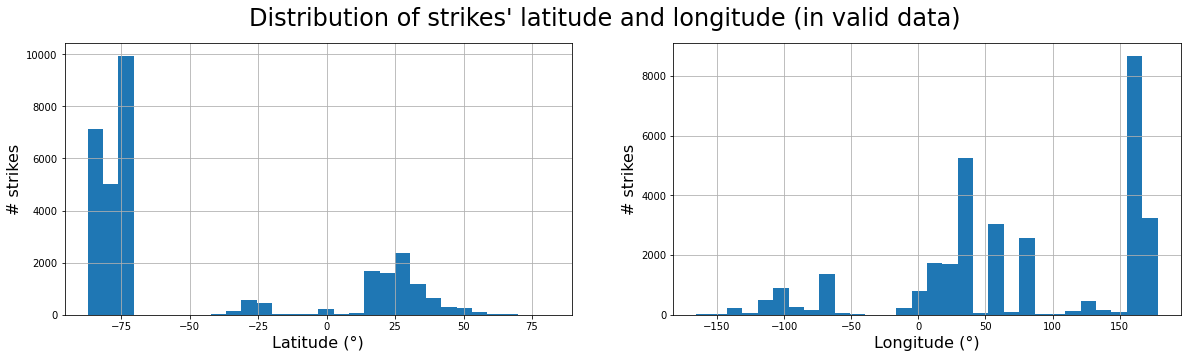

In [18]:
# Plot latitude and longitude
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
plt.suptitle("Distribution of strikes' latitude and longitude (in valid data)", fontsize = 24)
ax[0].set_xlabel('Latitude (°)', fontsize = 16)
ax[0].set_ylabel('# strikes', fontsize = 16)
ax[1].set_xlabel('Longitude (°)', fontsize = 16)
ax[1].set_ylabel('# strikes', fontsize = 16)
_ = valid_data.reclat.hist(bins = 30, ax = ax[0])
_ = valid_data.reclong.hist(bins = 30, ax = ax[1])

# Save figure
plt.savefig('geoloc.png')

390 classes


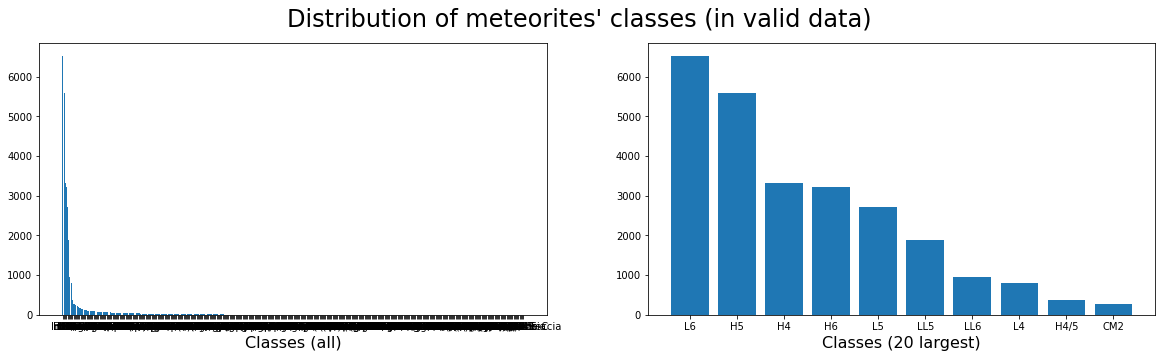

In [19]:
# Show some class statistics
num_classes = valid_data.recclass.nunique()
print(f"{num_classes} classes")

# Plot distribution of classes
fig, ax = plt.subplots(1, 2, figsize = (20, 5))
plt.suptitle("Distribution of meteorites' classes (in valid data)", fontsize = 24)
ax[0].set_xlabel('Classes (all)', fontsize = 16)
ax[1].set_xlabel('Classes (20 largest)', fontsize = 16)
class_sizes = valid_data.groupby(['recclass']).size().sort_values(ascending = False)
largest_classes = class_sizes[:10]
_ = ax[0].bar(class_sizes.index, class_sizes.values)
_ = ax[1].bar(largest_classes.index, largest_classes.values)

# Save figure
plt.savefig('classes.png')

We can see the 10 classes with the largest number of elements are: L6, H5, H4, H6, L5, LL5, LL6, L5, H4/5, CM2

Min year = 860, median year = 1991, max year = 2013


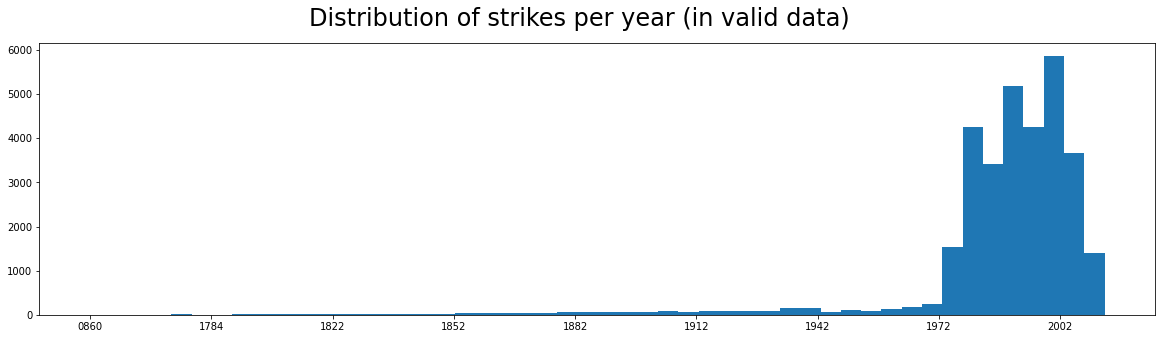

In [20]:
# Some date statistics
sorted_dates = valid_data.year.sort_values()
min_year, med_year, max_year = int(sorted_dates.min()), int(sorted_dates.median()), int(sorted_dates.max())
print(f"Min year = {min_year}, median year = {med_year}, max year = {max_year}")

# Plot distribution per year
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
fig.suptitle("Distribution of strikes per year (in valid data)", fontsize = 24)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
_ = sorted_dates.hist(bins = 50, grid = False, ax = ax)

# Save figure
plt.savefig('years.png')

Mean mass = 18553.344917896648 g
Median = 29.68 g


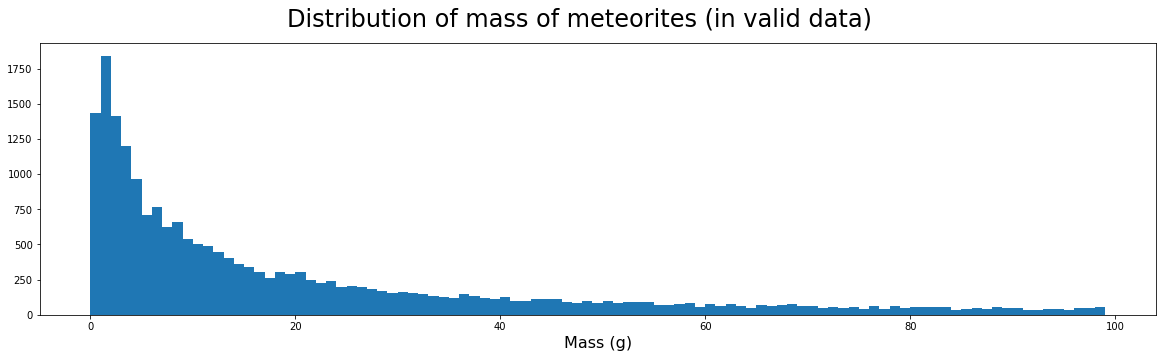

In [21]:
# Print mass statistics
mean, median = valid_data.mass.mean(), valid_data.mass.median()
print(f"Mean mass = {mean} g\nMedian = {median} g")

# Plot mass distribution
fig, ax = plt.subplots(1, 1, figsize = (20, 5))
fig.suptitle("Distribution of mass of meteorites (in valid data)", fontsize = 24)
ax.set_xlabel("Mass (g)", fontsize = 16)
_ = plt.hist(valid_data.mass, bins=list(range(100)))

# Save figure
plt.savefig('mass.png')

Number which was found = 1064 (3 %)
Number which fell = 30847 (96 %)


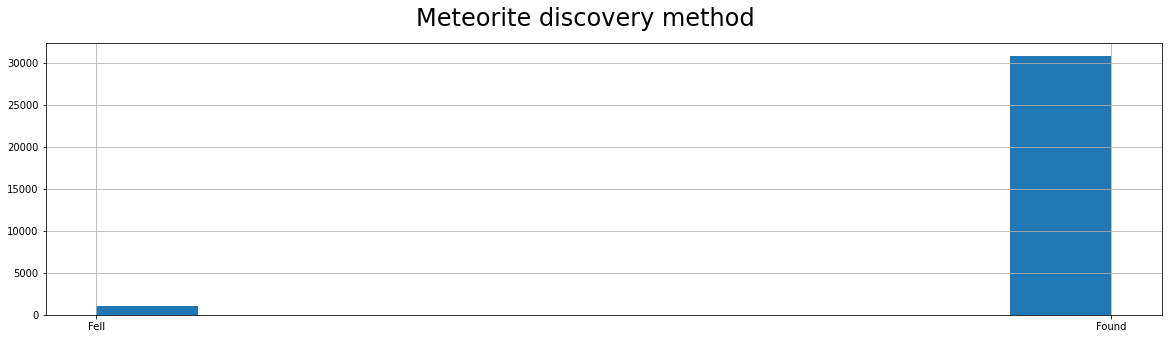

In [22]:
# Discovery method statistics
num_fell, num_found = valid_data.fall[valid_data.fall == "Fell"].count(), valid_data.fall[valid_data.fall == "Found"].count()
num_total = valid_data.fall[(valid_data.fall == "Fell") | (valid_data.fall == "Found")].count()
print(f"Number which was found = {num_fell} ({int(num_fell * 100 / num_total)} %)")
print(f"Number which fell = {num_found} ({int(num_found * 100 / num_total)} %)")

# Plot discovery method
fig = plt.figure(figsize = (20, 5))
fig.suptitle("Meteorite discovery method", fontsize = 24)
_ = valid_data.fall.hist()

# Save figure
plt.savefig('discovery.png')